# PersistentDataset, CacheDataset, and simple Dataset Tutorial and Speed Test

This tutorial shows how to accelerate PyTorch medical DL program based on
how data is loaded and preprocessed using different MONAI `Dataset` managers.

`Dataset` provides the simplest model of data loading.  Each time a dataset is needed, it is reloaded from the original datasources, and processed through the all non-random and random transforms to generate analyzable tensors. This mechanism has the smallest memory footprint, and the smallest temporary disk footprint.

`CacheDataset` provides a mechanism to pre-load all original data and apply non-random transforms into analyzable tensors loaded in memory prior to starting analysis.  The `CacheDataset` requires all tensor representations of data requested to be loaded into memory at once. The subset of random transforms are applied to the cached components before use. This is the highest performance dataset if all data fits in core memory.

`PersistentDataset` processes original data sources through the non-random transforms on first use, and stores these intermediate tensor values to an on-disk persistence representation.  The intermediate processed tensors are loaded from disk on each use for processing by the random-transforms for each analysis request.  The `PersistentDataset` has a similar memory footprint to the simple `Dataset`, with performance characterisics close to the `CacheDataset` at the expense of disk storage.  Additially, the cost of first time processing of data is distributed across each first use.

It's modified from the Spleen 3D segmentation tutorial notebook.

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import glob
import time
import time
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from monai.data import Dataset, PersistentDataset, CacheDataset
from monai.transforms import \
    Compose, LoadNiftid, AddChanneld, ScaleIntensityRanged, CropForegroundd, \
    RandCropByPosNegLabeld, RandAffined, Spacingd, Orientationd, ToTensord
from monai.data import list_data_collate
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import compute_meandice
from monai.utils import set_determinism

## Define a typical PyTorch training process

In [2]:
def train_process(train_ds, val_ds):
    # use batch_size=2 to load images and use RandCropByPosNegLabeld
    # to generate 2 x 4 images for network training
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4, collate_fn=list_data_collate)
    val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
    device = torch.device('cuda:0')
    model = UNet(dimensions=3, in_channels=1, out_channels=2, channels=(16, 32, 64, 128, 256),
                 strides=(2, 2, 2, 2), num_res_units=2, norm=Norm.BATCH).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)

    epoch_num = 600
    val_interval = 1  # do validation for every epoch
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = list()
    metric_values = list()
    epoch_times = list()
    total_start = time.time()
    for epoch in range(epoch_num):
        epoch_start = time.time()
        print('-' * 10)
        print('epoch {}/{}'.format(epoch + 1, epoch_num))
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print('{}/{}, train_loss: {:.4f}, step time: {:.4f}'.format(
                  step, len(train_ds) // train_loader.batch_size, loss.item(), time.time() - step_start))
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print('epoch {} average loss: {:.4f}'.format(epoch + 1, epoch_loss))

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                metric_sum = 0.
                metric_count = 0
                for val_data in val_loader:
                    val_inputs, val_labels = val_data['image'].to(device), val_data['label'].to(device)
                    roi_size = (160, 160, 160)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                    value = compute_meandice(y_pred=val_outputs, y=val_labels, include_background=False,
                                             to_onehot_y=True, mutually_exclusive=True)
                    metric_count += len(value)
                    metric_sum += value.sum().item()
                metric = metric_sum / metric_count
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), 'best_metric_model.pth')
                    print('saved new best metric model')
                print('current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}'.format(
                    epoch + 1, metric, best_metric, best_metric_epoch))
        print('time consuming of epoch {} is: {:.4f}'.format(epoch + 1, time.time() - epoch_start))
        epoch_times.append(time.time() - epoch_start)
    print('train completed, best_metric: {:.4f} at epoch: {}, total time: {:.4f}'.format(
        best_metric, best_metric_epoch, time.time() - total_start))
    return epoch_num, time.time() - total_start, epoch_loss_values, metric_values, epoch_times

# Start of speed testing

The `PersistenceDataset`, `CacheDataset`, and `Dataset` are compared for speed for running 600 epochs.

## Define the MSD Spleen dataset path

In [3]:
data_root = '/workspace/data/medical/Task09_Spleen'
train_images = sorted(glob.glob(os.path.join(data_root, 'imagesTr', '*.nii.gz')))
train_labels = sorted(glob.glob(os.path.join(data_root, 'labelsTr', '*.nii.gz')))
data_dicts = [{'image': image_name, 'label': label_name}
              for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Setup transforms for training and validation
  
Deterministic transforms during training:  
- LoadNiftid  
- AddChanneld  
- Spacingd  
- Orientationd  
- ScaleIntensityRanged  
  
Non-deterministic transforms:  
- RandCropByPosNegLabeld  
- ToTensord

All the validation transforms are deterministic.  
The results of all the deterministic transforms will be cached to accelerate training.

In [4]:
def transformations():
    train_transforms = Compose([
        LoadNiftid(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), mode=('bilinear', 'nearest')),
        Orientationd(keys=['image', 'label'], axcodes='RAS'),
        ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        # randomly crop out patch samples from big image based on pos / neg ratio
        # the image centers of negative samples must be in valid image area
        RandCropByPosNegLabeld(keys=['image', 'label'], label_key='label', spatial_size=(96, 96, 96), pos=1,
                               neg=1, num_samples=4, image_key='image', image_threshold=0),
        ToTensord(keys=['image', 'label'])
    ])

    # NOTE: No random cropping in the validation data, we will evaluate the entire image using a sliding window.
    val_transforms = Compose([
        LoadNiftid(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), mode=('bilinear', 'nearest')),
        Orientationd(keys=['image', 'label'], axcodes='RAS'),
        ScaleIntensityRanged(keys=['image'], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        ToTensord(keys=['image', 'label'])
    ])
    return train_transforms, val_transforms

## Enable deterministic training and regular `Dataset`

Load each original dataset and transform each time it is needed.

In [ ]:
set_determinism(seed=0)
train_trans, val_trans = transformations()
train_ds = Dataset(data=train_files, transform=train_trans)
val_ds = Dataset(data=val_files, transform=val_trans)

epoch_num, total_time, epoch_loss_values, metric_values, epoch_times = train_process(train_ds, val_ds)
print('Total training time of {} epochs with regular Dataset: {:.4f}'.format(epoch_num, total_time))

## Enable deterministic training and `PersistentDataset`

Use persistent storage of non-random transformed training and validation data computed once and stored in persistently across runs

In [ ]:
persistent_cache: Path = Path("./persistent_cache")
persistent_cache.mkdir(parents=True, exist_ok=True)

set_determinism(seed=0)
train_trans, val_trans = transformations()
train_persitence_ds = PersistentDataset(data=train_files, transform=train_trans, cache_dir=persistent_cache)
val_persitence_ds = PersistentDataset(data=val_files, transform=val_trans, cache_dir=persistent_cache)

persistence_epoch_num, persistence_total_time, persistence_epoch_loss_values, \
    persistence_metric_values, persistence_epoch_times = \
    train_process(train_persitence_ds, val_persitence_ds)
print('Total training time of {} epochs with persistent storage Dataset: {:.4f}'.format(
    persistence_epoch_num, persistence_total_time))

## Enable deterministic training and `CacheDataset`

Precompute all non-random transforms of original data and store in memory.

In [ ]:
set_determinism(seed=0)
train_trans, val_trans = transformations()
cache_init_start = time.time()
cache_train_ds = CacheDataset(data=train_files, transform=train_trans, cache_rate=1.0, num_workers=4)
cache_val_ds = CacheDataset(data=val_files, transform=val_trans, cache_rate=1.0, num_workers=4)
cache_init_time = time.time() - cache_init_start

cache_epoch_num, cache_total_time, cache_epoch_loss_values, cache_metric_values, cache_epoch_times = \
    train_process(cache_train_ds, cache_val_ds)
print('Total training time of {} epochs with CacheDataset: {:.4f}'.format(cache_epoch_num, cache_total_time))

## Plot training loss and validation metrics

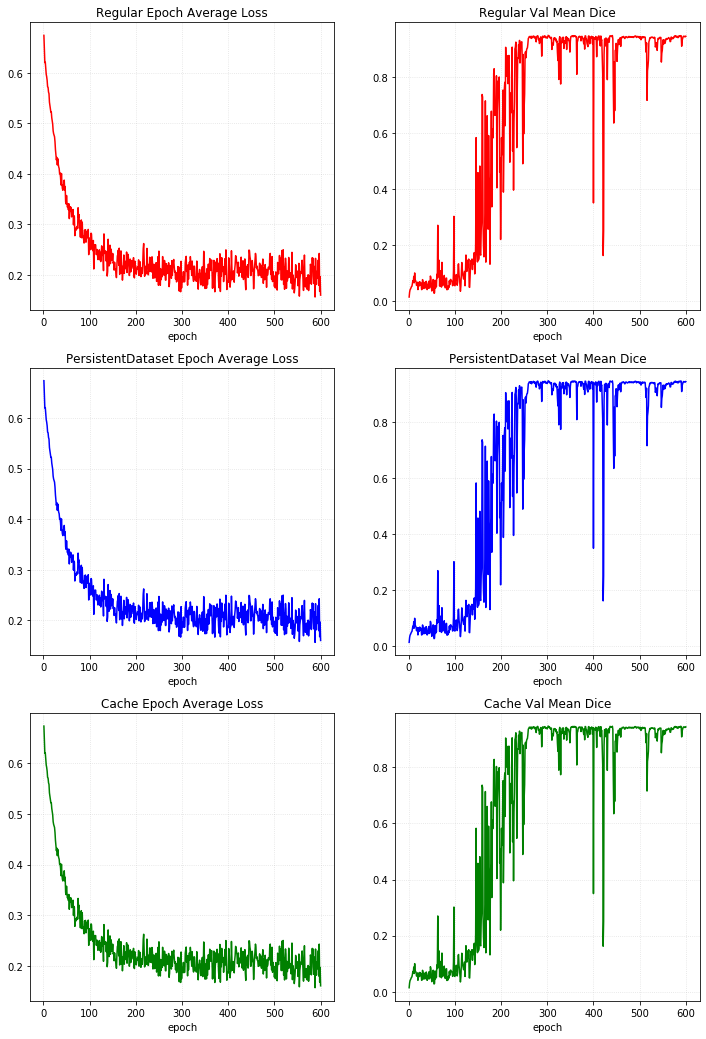

In [9]:
plt.figure('train', (12, 18))
plt.subplot(3, 2, 1)
plt.title('Regular Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='red')

plt.subplot(3, 2, 2)
plt.title('Regular Val Mean Dice')
x = [i + 1 for i in range(len(metric_values))]
y = cache_metric_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='red')

plt.subplot(3, 2, 3)
plt.title('PersistentDataset Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = persistence_epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='blue')

plt.subplot(3, 2, 4)
plt.title('PersistentDataset Val Mean Dice')
x = [i + 1 for i in range(len(metric_values))]
y = persistence_metric_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='blue')

plt.subplot(3, 2, 5)
plt.title('Cache Epoch Average Loss')
x = [i + 1 for i in range(len(epoch_loss_values))]
y = cache_epoch_loss_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='green')

plt.subplot(3, 2, 6)
plt.title('Cache Val Mean Dice')
x = [i + 1 for i in range(len(metric_values))]
y = cache_metric_values
plt.xlabel('epoch')
plt.grid(alpha=0.4, linestyle=':')
plt.plot(x, y, color='green')

plt.show()

## Plot total time and every epoch time

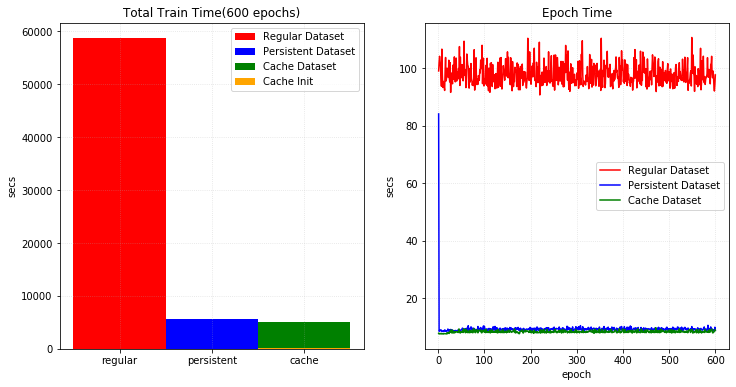

In [11]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title('Total Train Time(600 epochs)')
plt.bar('regular', total_time, 1, label='Regular Dataset', color='red')
plt.bar('persistent', persistence_total_time, 1, label='Persistent Dataset', color='blue')
plt.bar('cache', cache_init_time + cache_total_time, 1, label='Cache Dataset', color='green')
plt.bar('cache', cache_init_time, 1, label='Cache Init', color='orange')
plt.ylabel('secs')
plt.grid(alpha=0.4, linestyle=':')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Epoch Time')
x = [i + 1 for i in range(len(epoch_times))]
plt.xlabel('epoch')
plt.ylabel('secs')
plt.plot(x, epoch_times, label='Regular Dataset', color='red')
plt.plot(x, persistence_epoch_times, label='Persistent Dataset', color='blue')
plt.plot(x, cache_epoch_times, label='Cache Dataset', color='green')
plt.grid(alpha=0.4, linestyle=':')
plt.legend(loc='best')
plt.show()